In [131]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write


mkdir: data: File exists
--2023-03-20 12:59:01--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-03-20 12:59:02--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  1.59MB/s    in 5.0s    

2023-03-20 12:59:07 (1.44 MB/s) - ‘data/pbmc

In [132]:
#tried both the dataframe-image package and the below one, df2img. 
#could not resolve the errors in using the export function in dataframe-image
#so switched to using df2img
pip install df2img

Note: you may need to restart the kernel to use updated packages.


In [133]:
import numpy as np
import pandas as pd
import scanpy as sc
import leidenalg
import df2img

In [134]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.22.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [135]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results


In [136]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [137]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [138]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


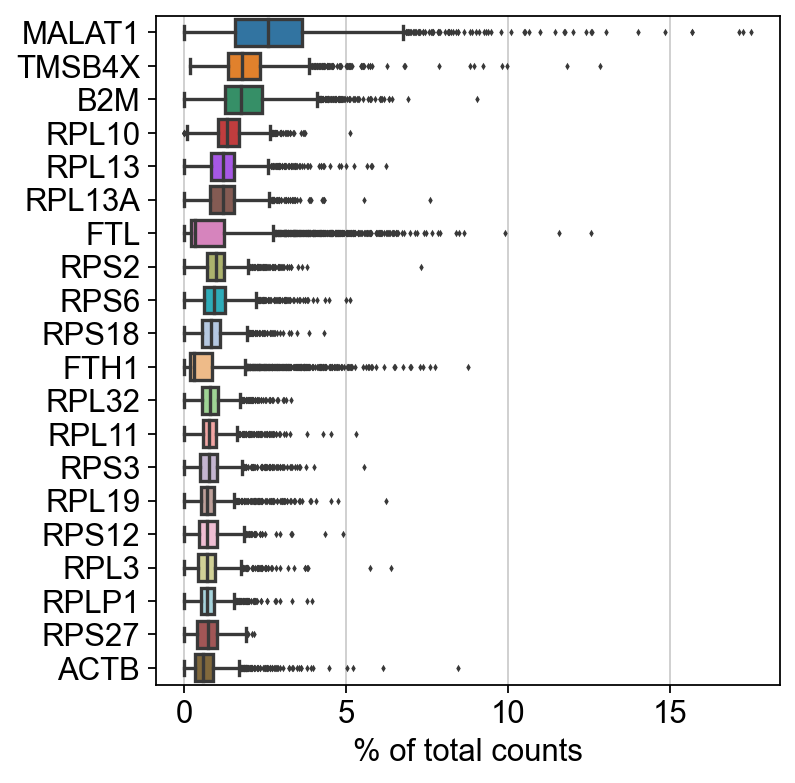

In [139]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [140]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detected in less than 3 cells


In [141]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


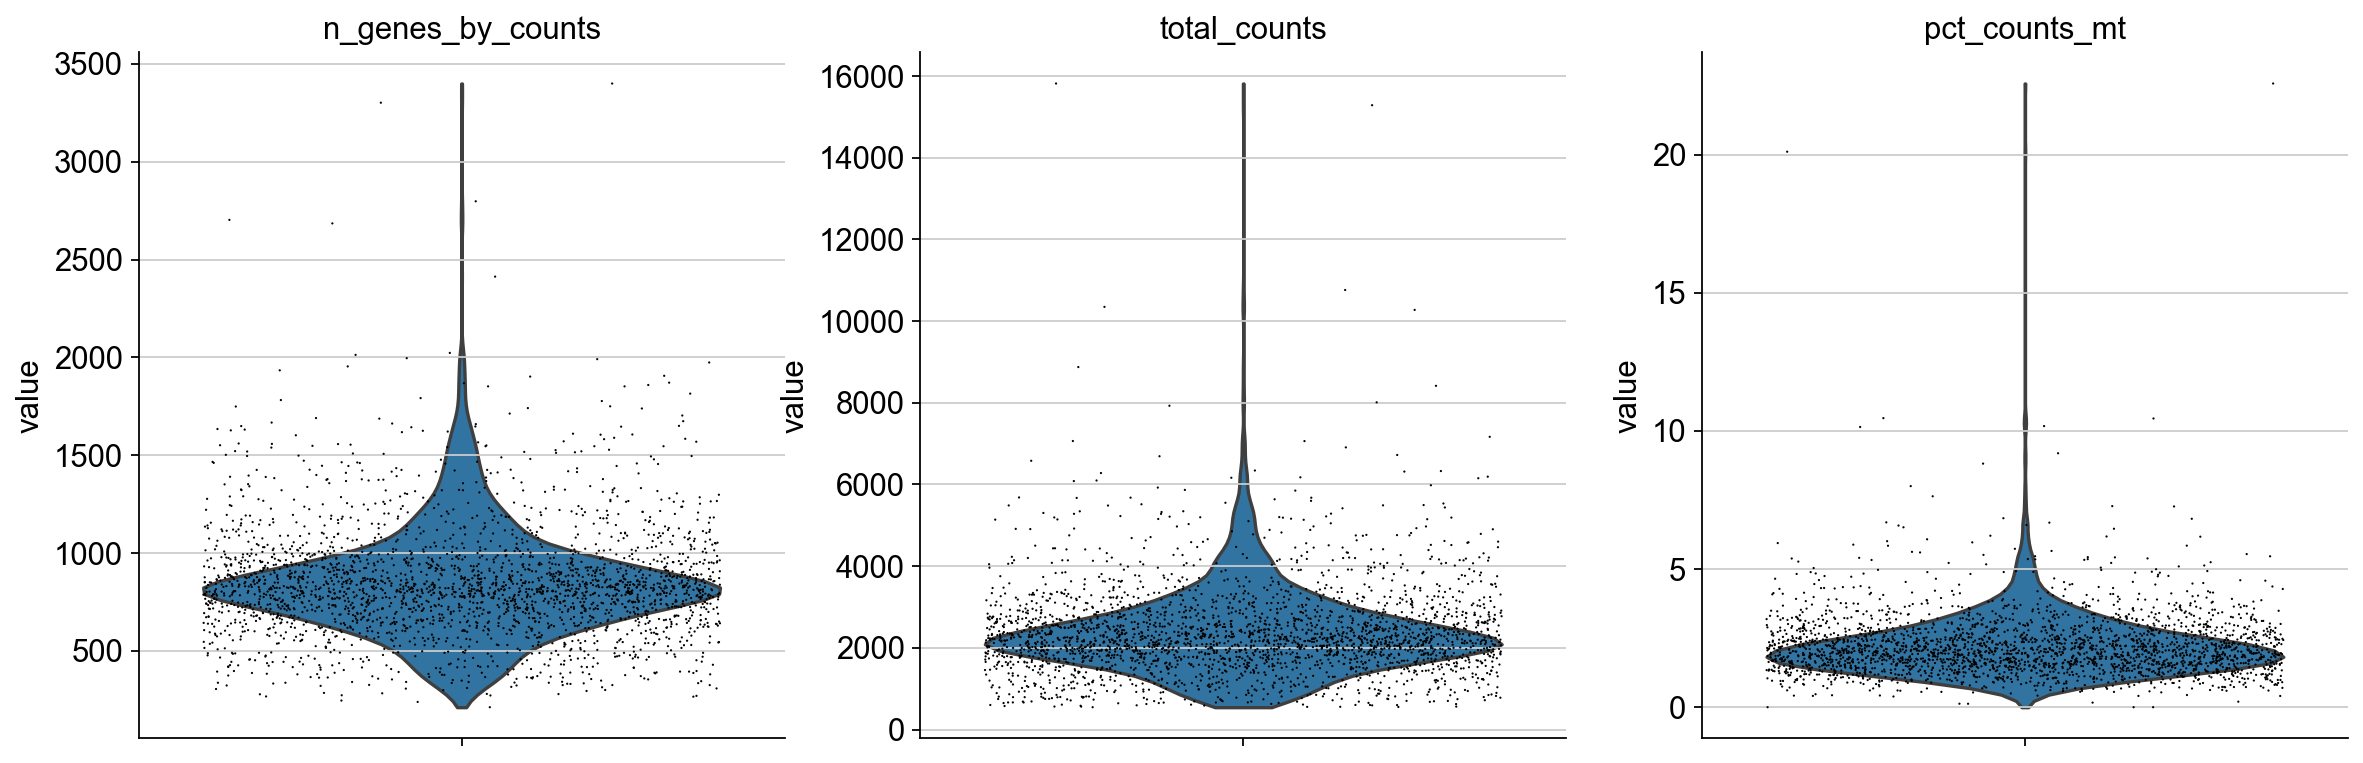

In [142]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


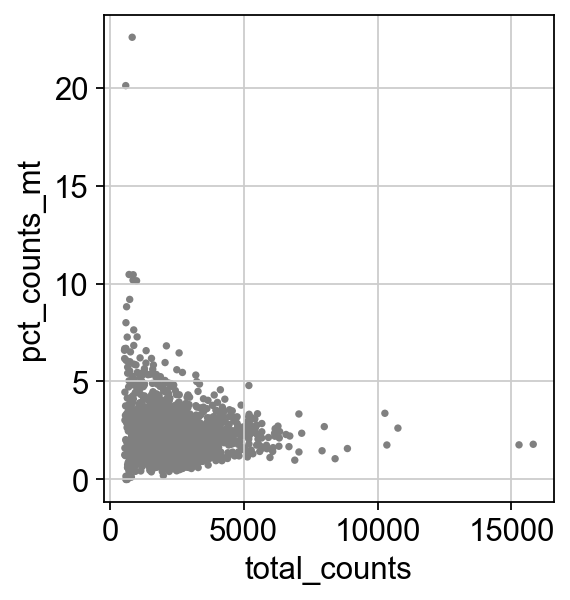

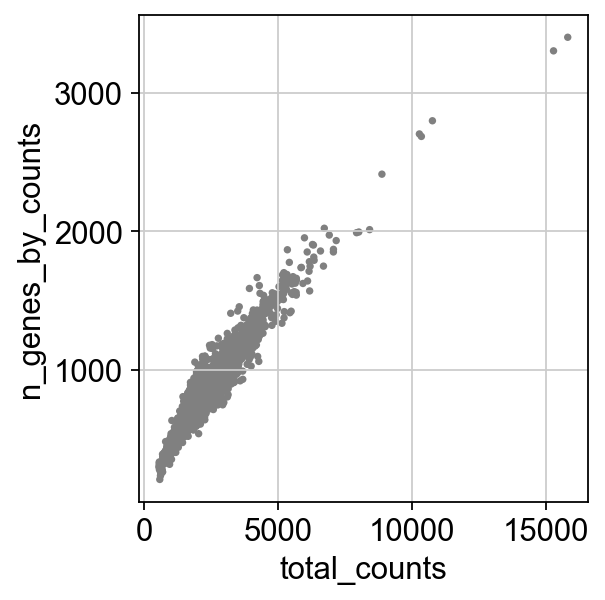

In [143]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [144]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]


In [145]:
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


/Users/mvelyuns/.pyenv/versions/3.8.16/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning:

Revieved a view of an AnnData. Making a copy.



In [146]:
sc.pp.log1p(adata)


In [147]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


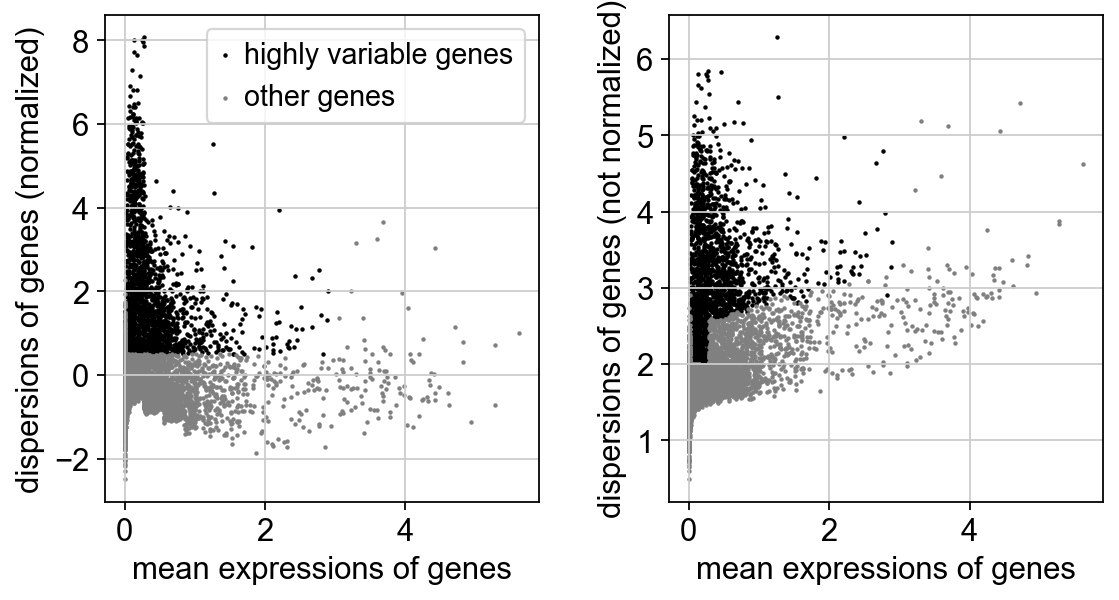

In [148]:
sc.pl.highly_variable_genes(adata)


In [149]:
adata.raw = adata


In [150]:
adata = adata[:, adata.var.highly_variable]


In [151]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [152]:
sc.pp.scale(adata, max_value=10)


In [153]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


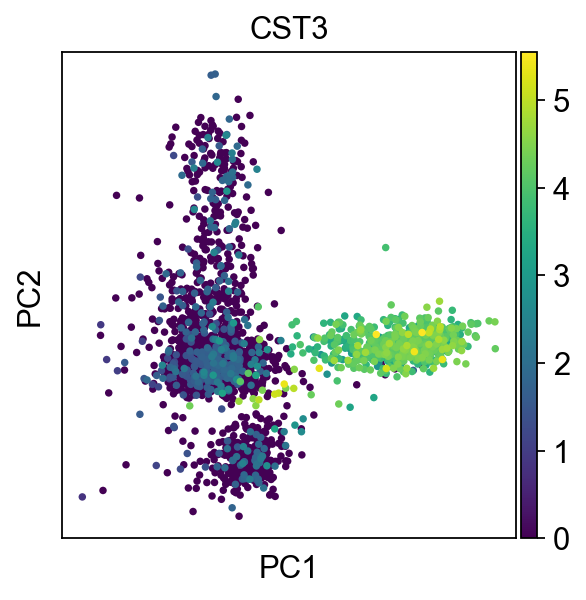

In [154]:
sc.pl.pca(adata, color='CST3')


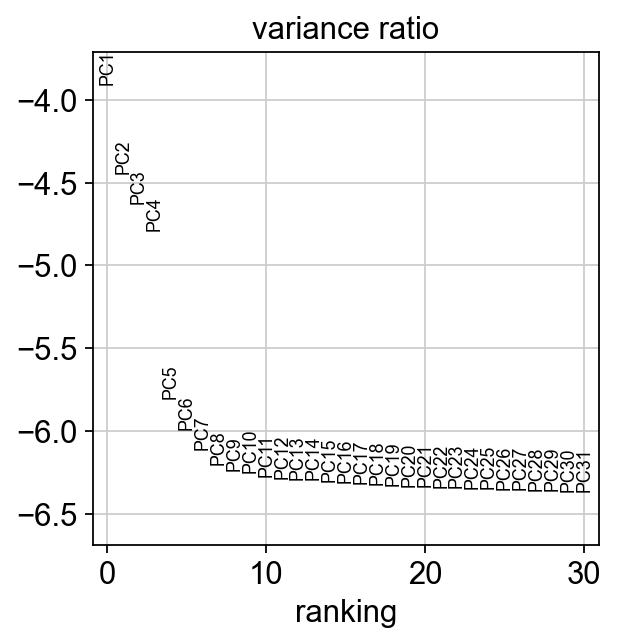

In [155]:
sc.pl.pca_variance_ratio(adata, log=True)


In [156]:
adata.write(results_file)


In [157]:
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [158]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [159]:
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [160]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


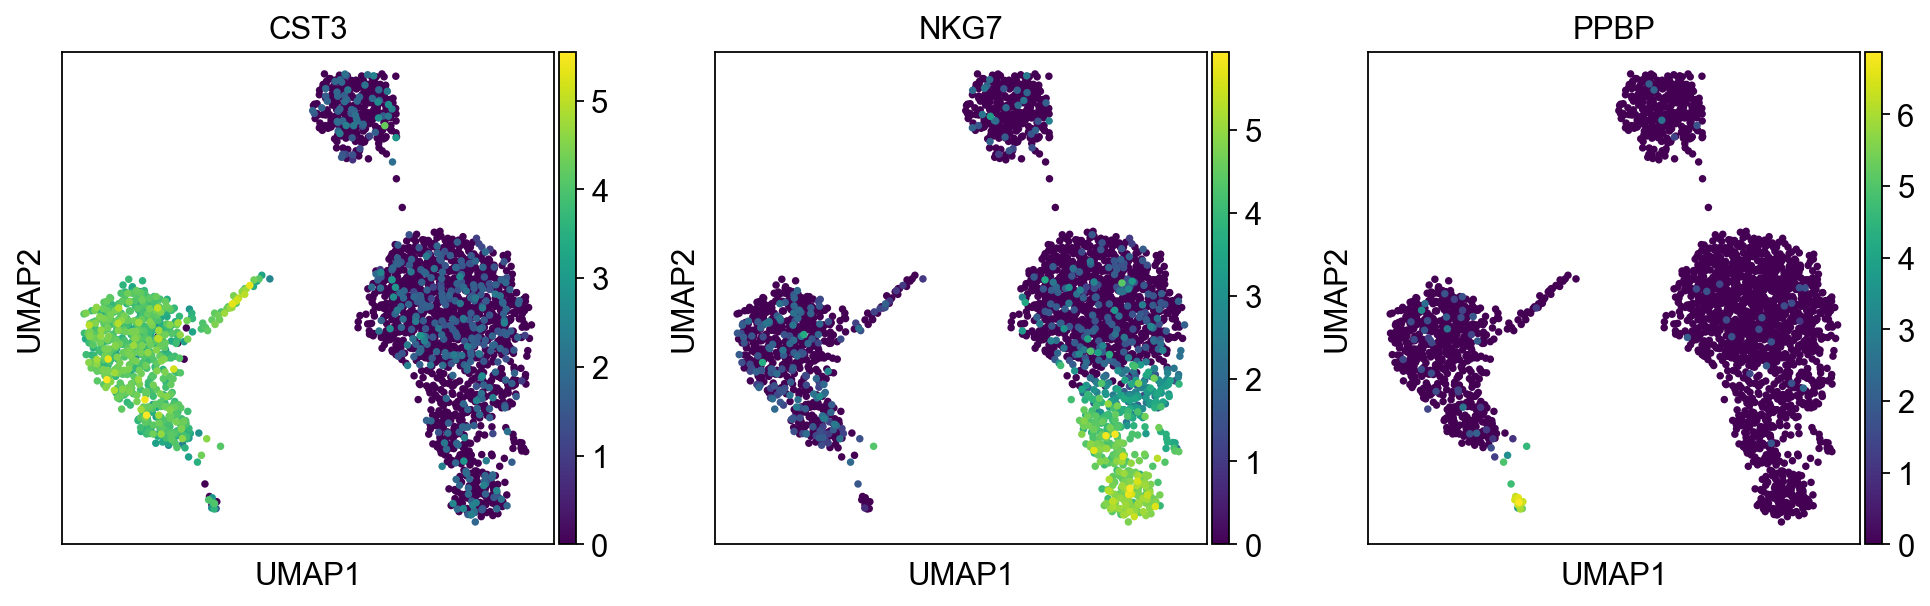

In [161]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


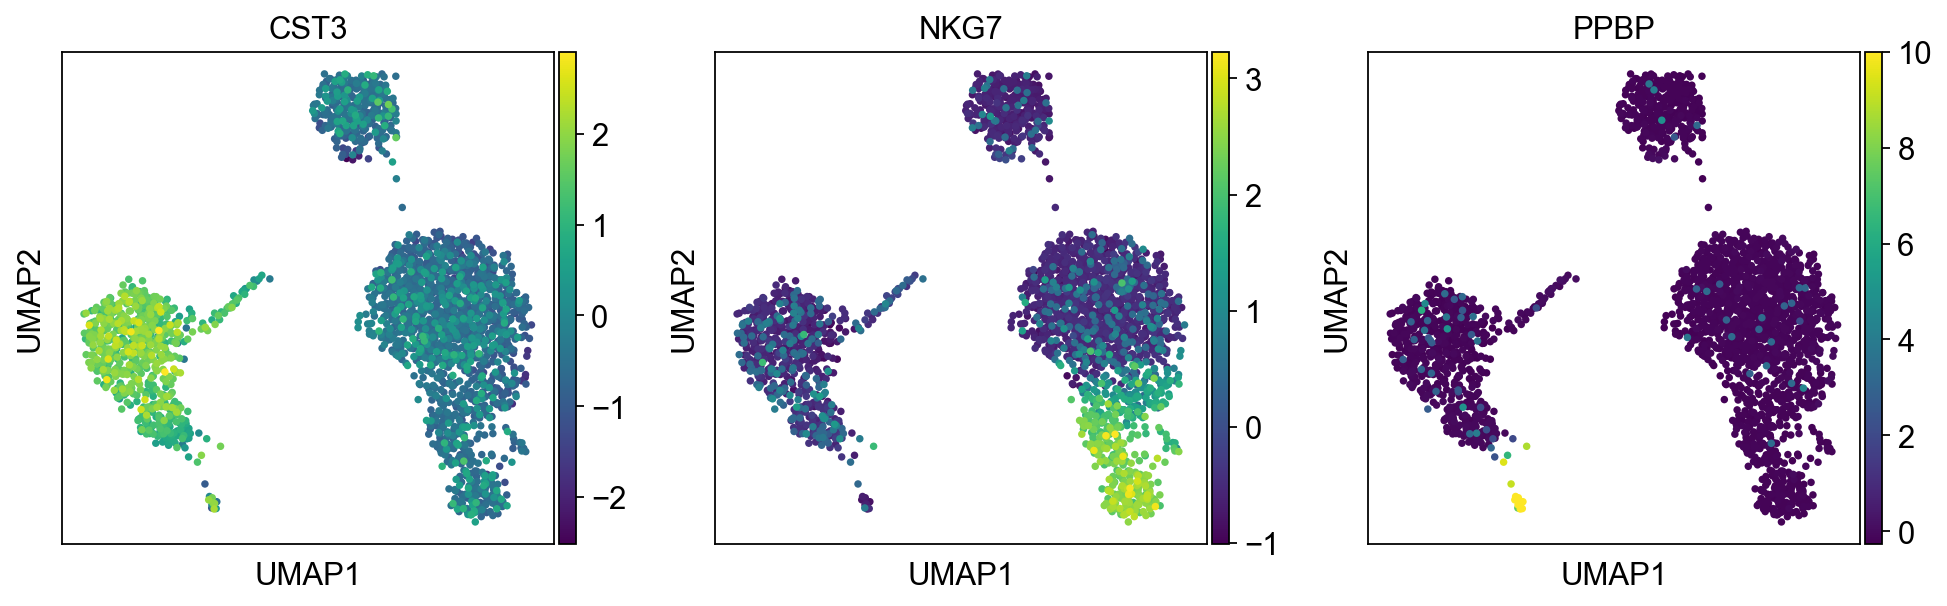

In [162]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


In [163]:
sc.tl.leiden(adata)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/mvelyuns/.pyenv/versions/3.8.16/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



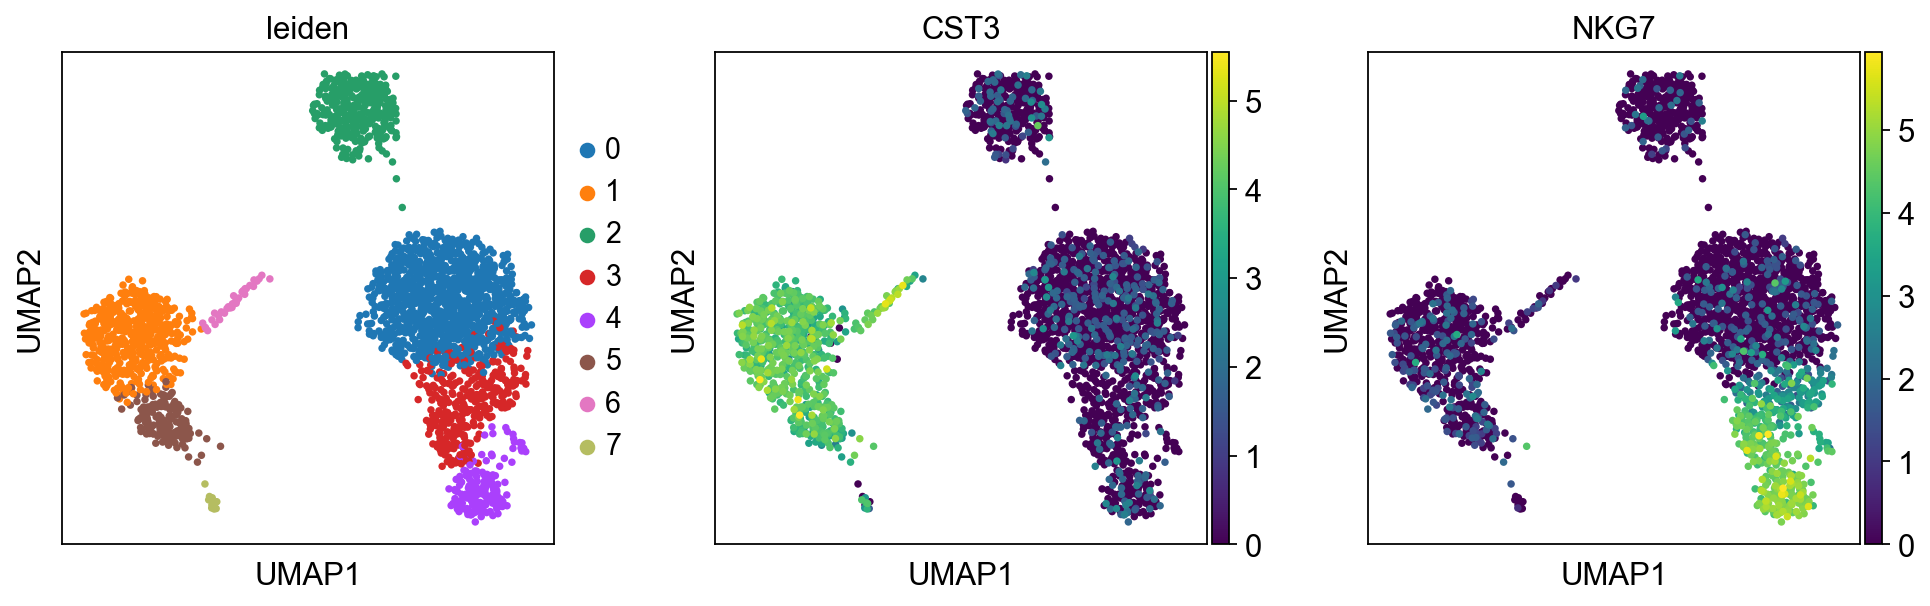

In [164]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


In [165]:
adata.write(results_file)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


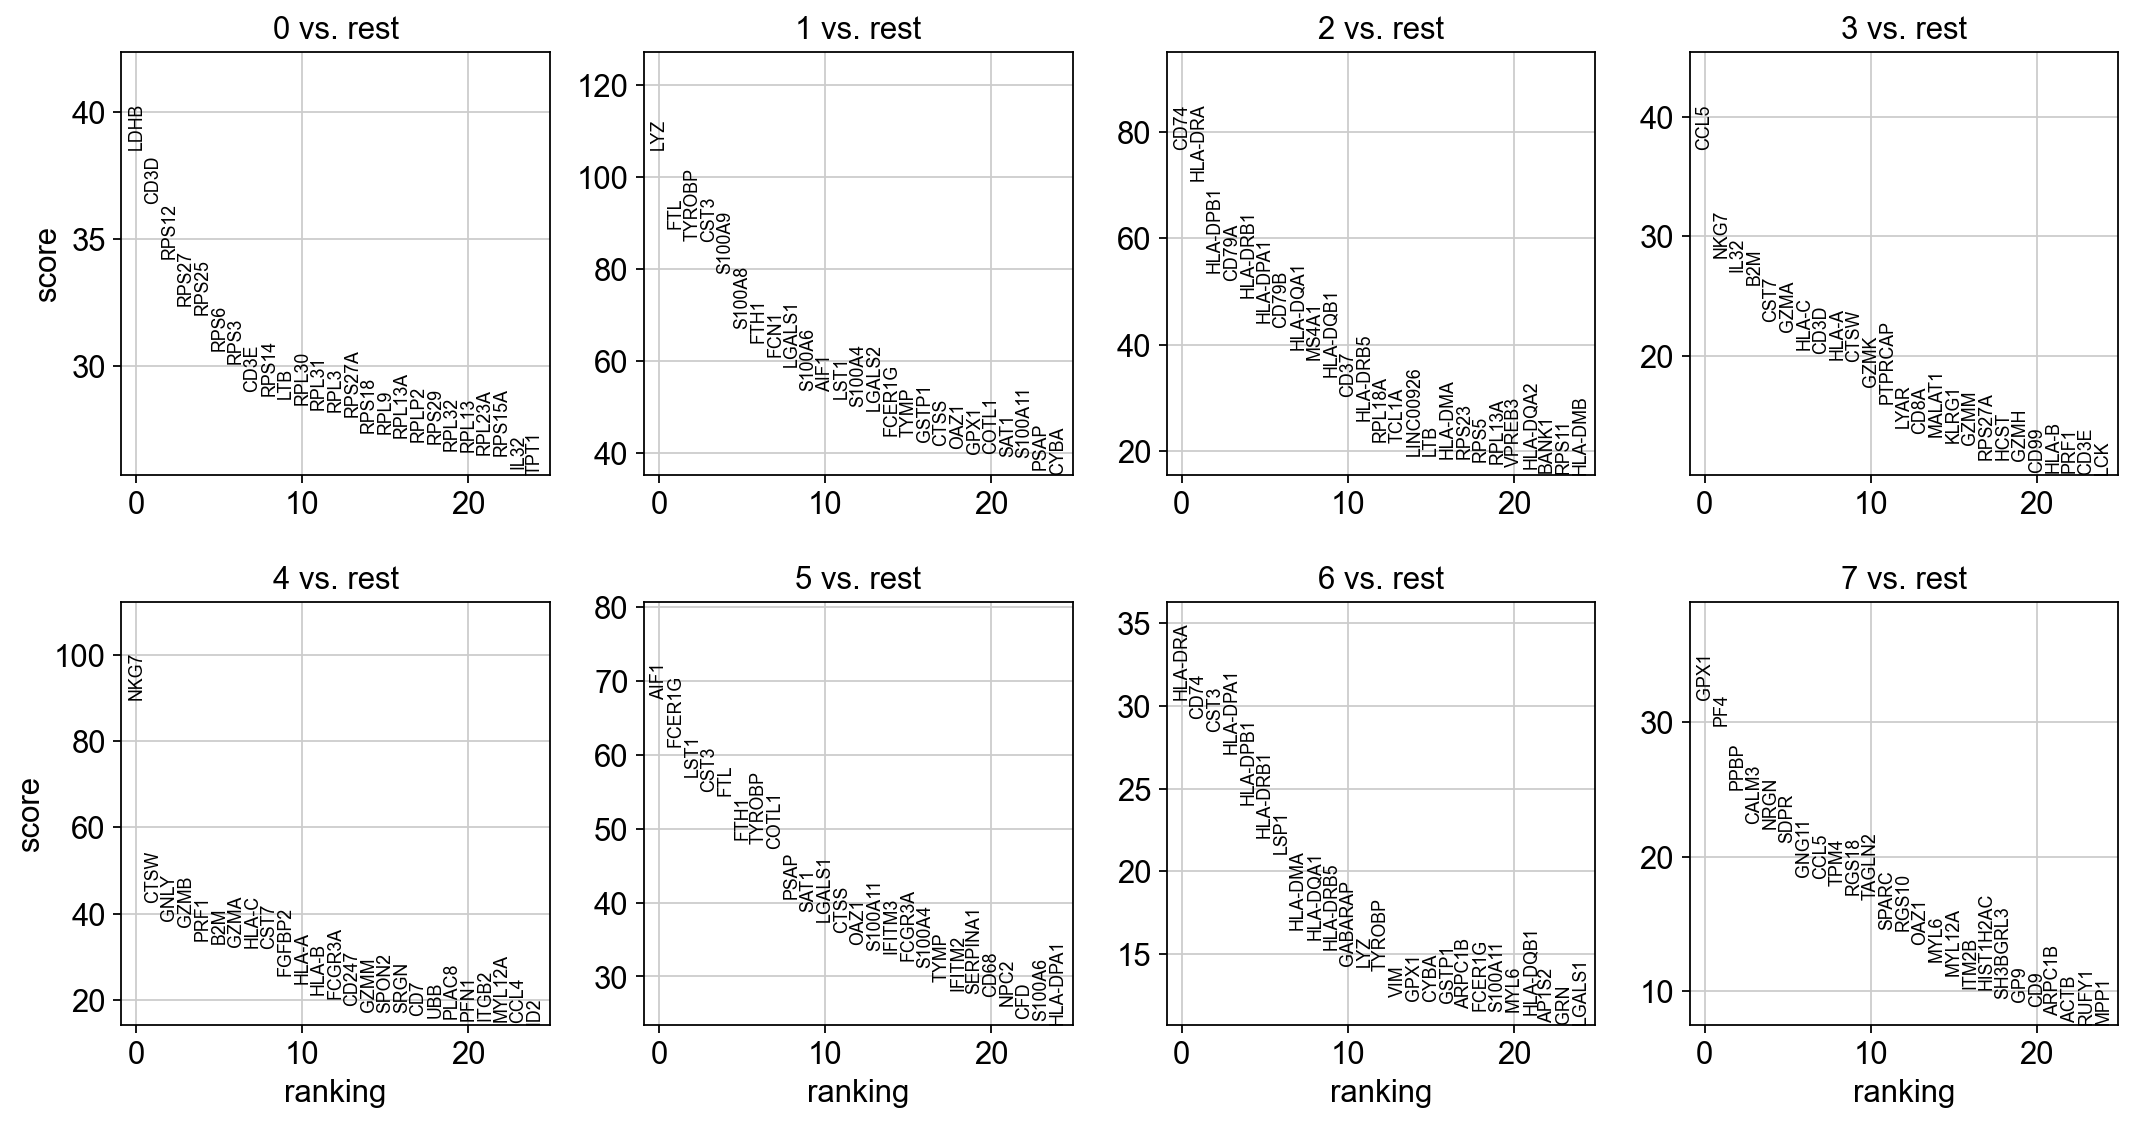

In [166]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [167]:
sc.settings.verbosity = 2  # reduce the verbosity


ranking genes
    finished (0:00:01)


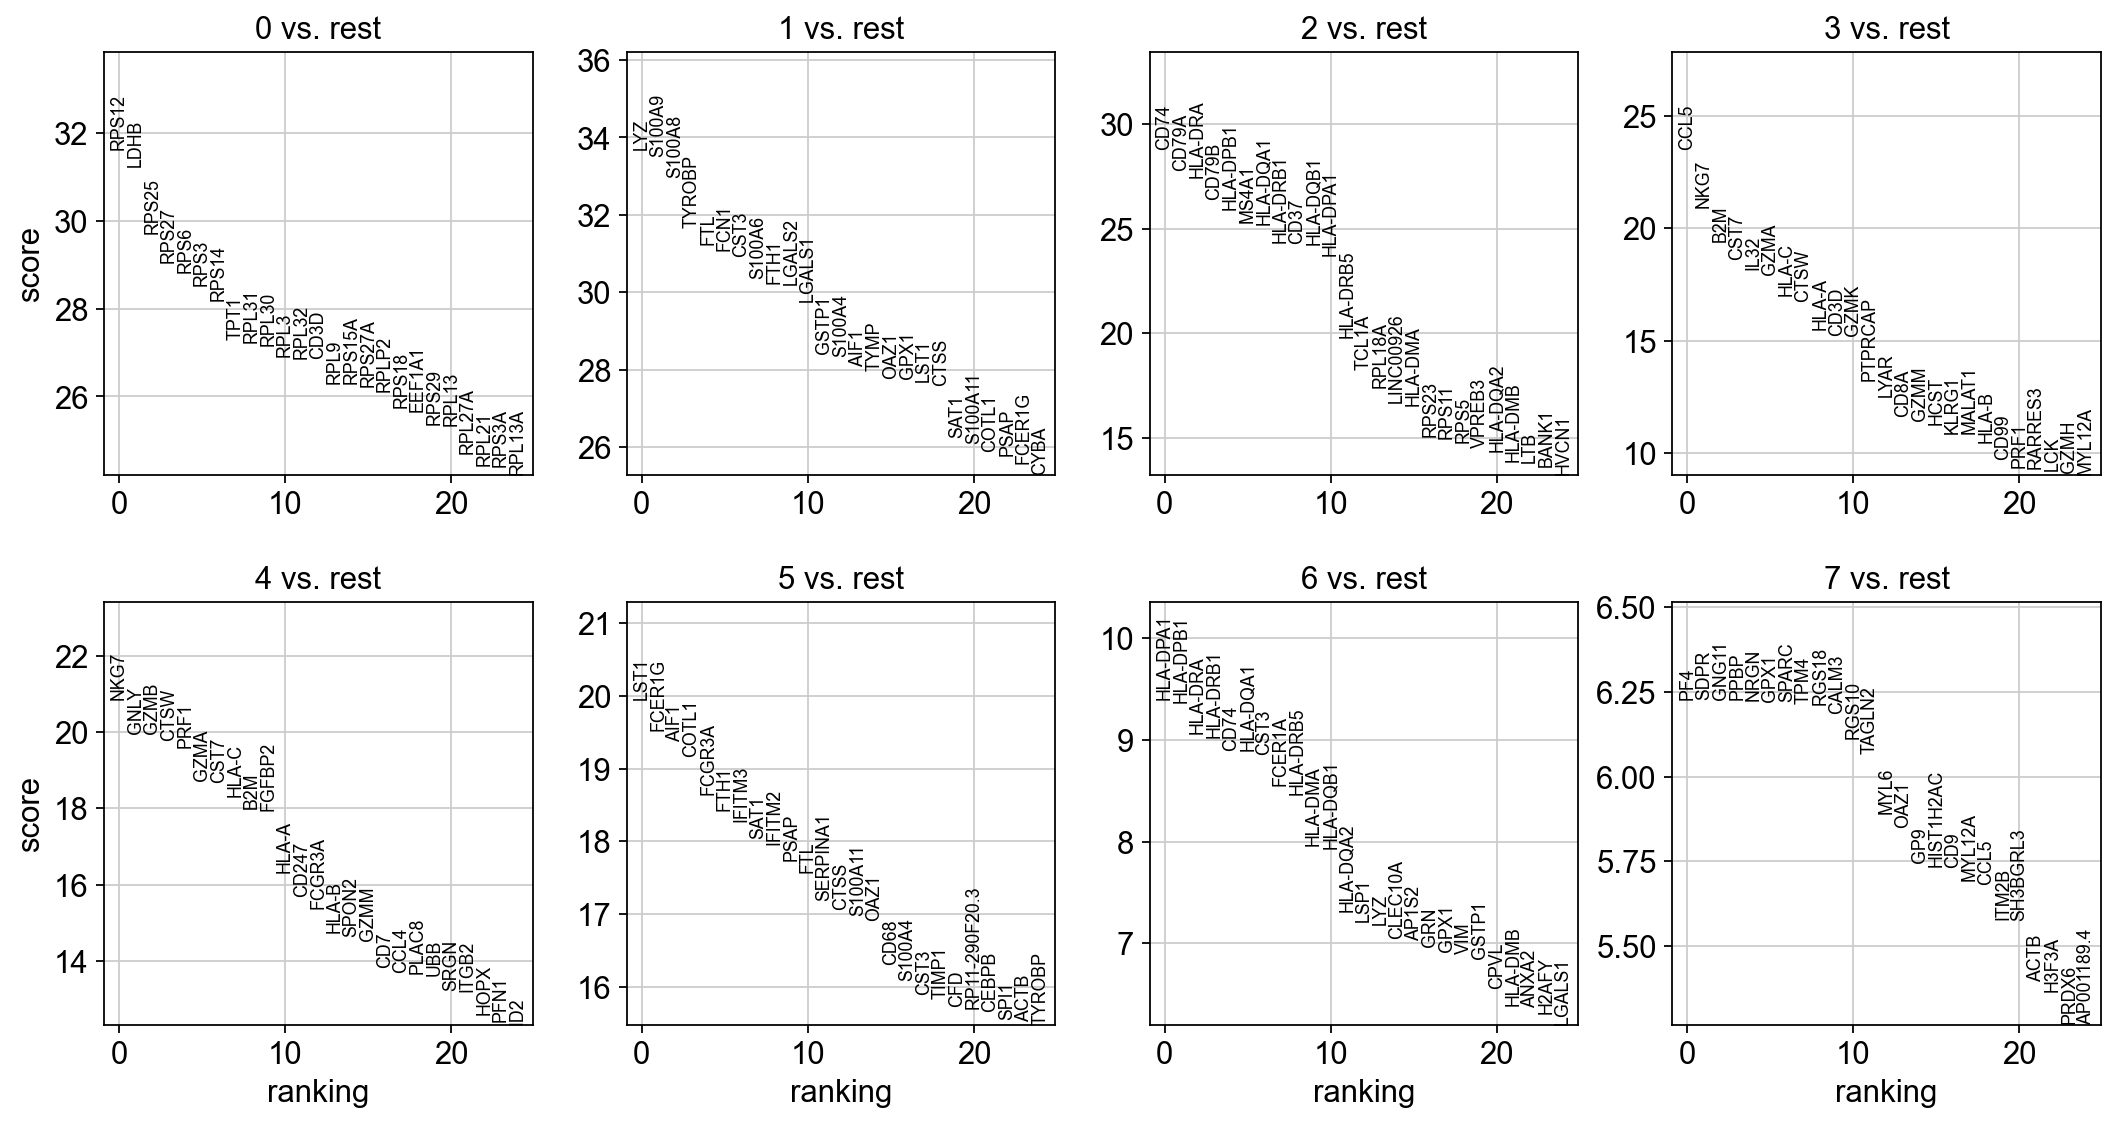

In [168]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [169]:
adata.write(results_file)


ranking genes
    finished (0:00:02)


/Users/mvelyuns/.pyenv/versions/3.8.16/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



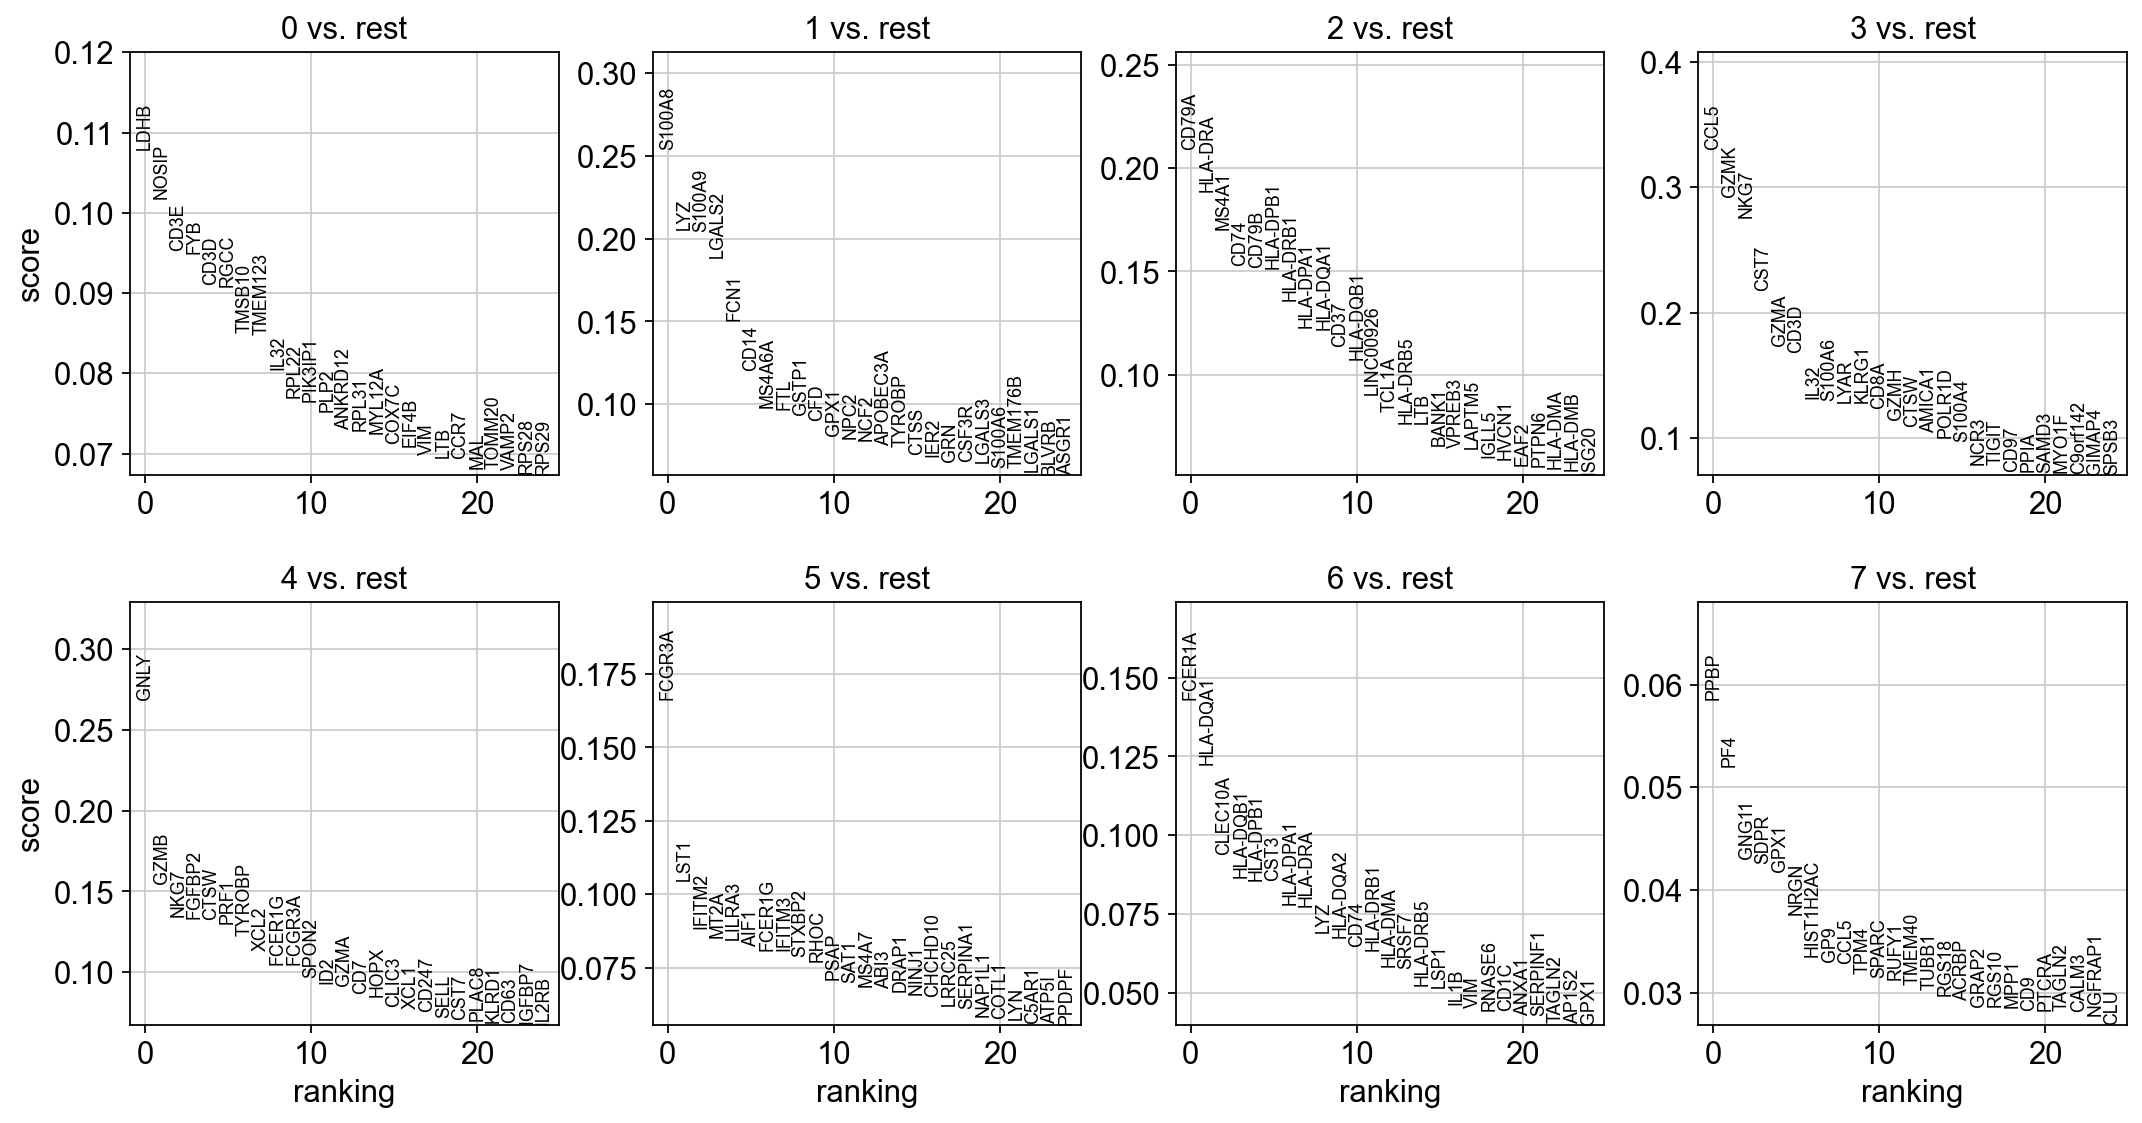

In [170]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [171]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']


In [172]:
adata = sc.read(results_file)


In [173]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GNLY  FCER1G  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  GZMB    AIF1   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  IL32  PRF1  FCGR3A      CD74   NRGN

In [174]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)


0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  1.404647e-219     LYZ  7.634876e-249      CD74  3.043536e-182  CCL5   
1   LDHB  2.805350e-214  S100A9  4.626358e-246     CD79A  6.860832e-170  NKG7   
2  RPS25  4.569889e-194  S100A8  1.622835e-238   HLA-DRA  8.398068e-166   B2M   
3  RPS27  1.164214e-185  TYROBP  2.957652e-220     CD79B  1.171444e-153  CST7   
4   RPS6  8.893675e-183     FTL  2.479195e-214  HLA-DPB1  6.167786e-148  IL32   

             3_p   4_n           4_p     5_n           5_p       6_n  \
0  3.380869e-122  NKG7  1.203971e-96    LST1  1.322111e-88  HLA-DPA1   
1   4.248878e-97  GNLY  1.257170e-88  FCER1G  6.259712e-85  HLA-DPB1   
2   5.449722e-84  GZMB  1.429027e-88    AIF1  1.348814e-83   HLA-DRA   
3   1.850639e-77  CTSW  4.144726e-87   COTL1  5.974694e-82  HLA-DRB1   
4   7.057861e-74  PRF1  1.692100e-85  FCGR3A  1.392377e-77      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

ranking genes
    finished (0:00:00)


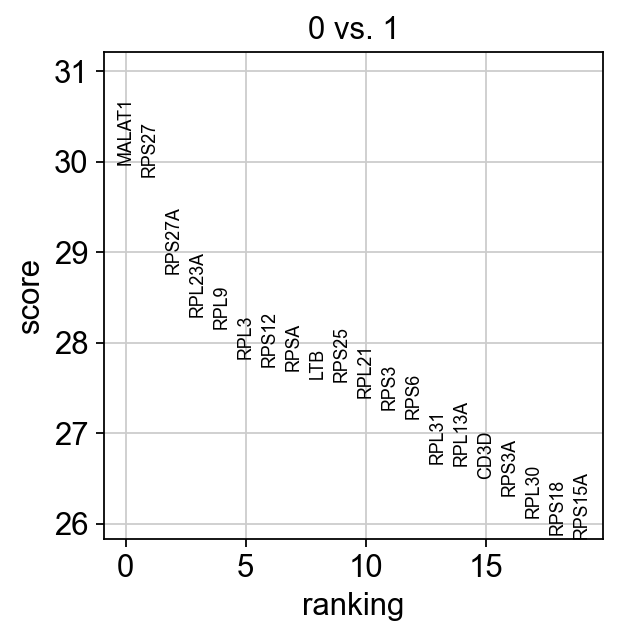

In [175]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)


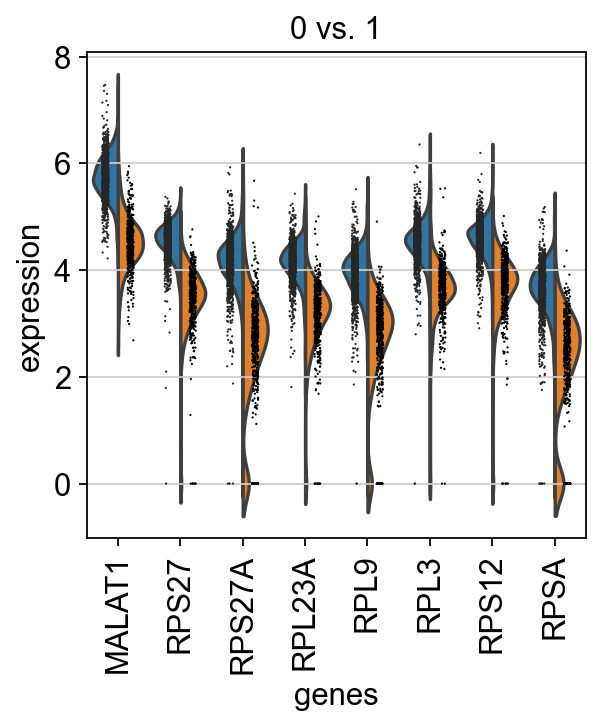

In [176]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [177]:
adata = sc.read(results_file)


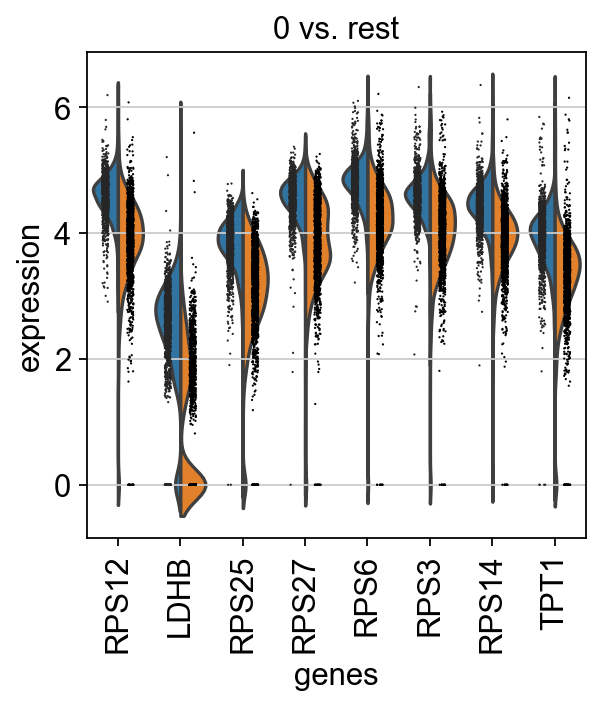

In [178]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


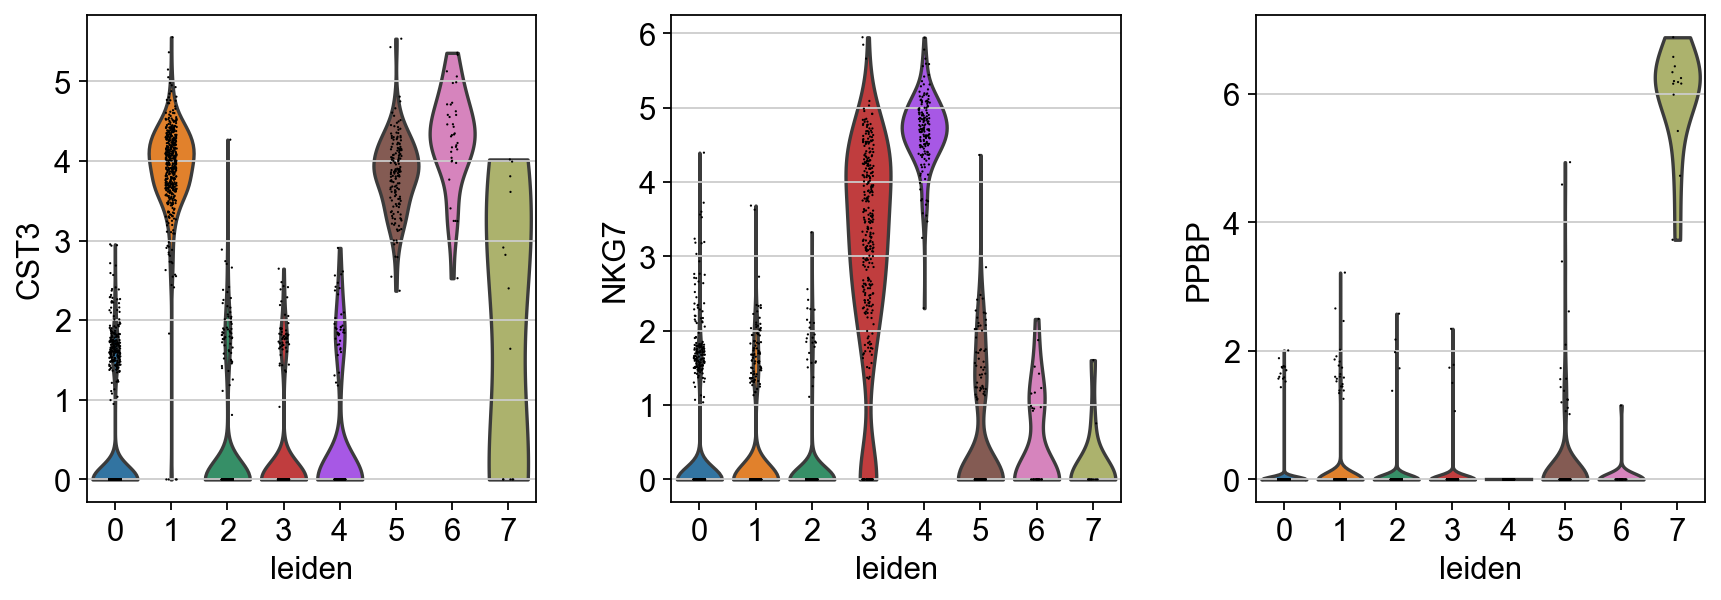

In [179]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')


In [180]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)


/Users/mvelyuns/.pyenv/versions/3.8.16/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning:

The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.



/Users/mvelyuns/.pyenv/versions/3.8.16/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



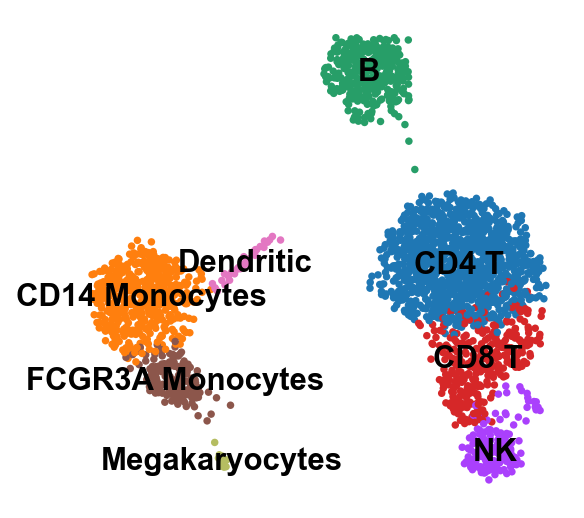

In [181]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


/Users/mvelyuns/.pyenv/versions/3.8.16/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored



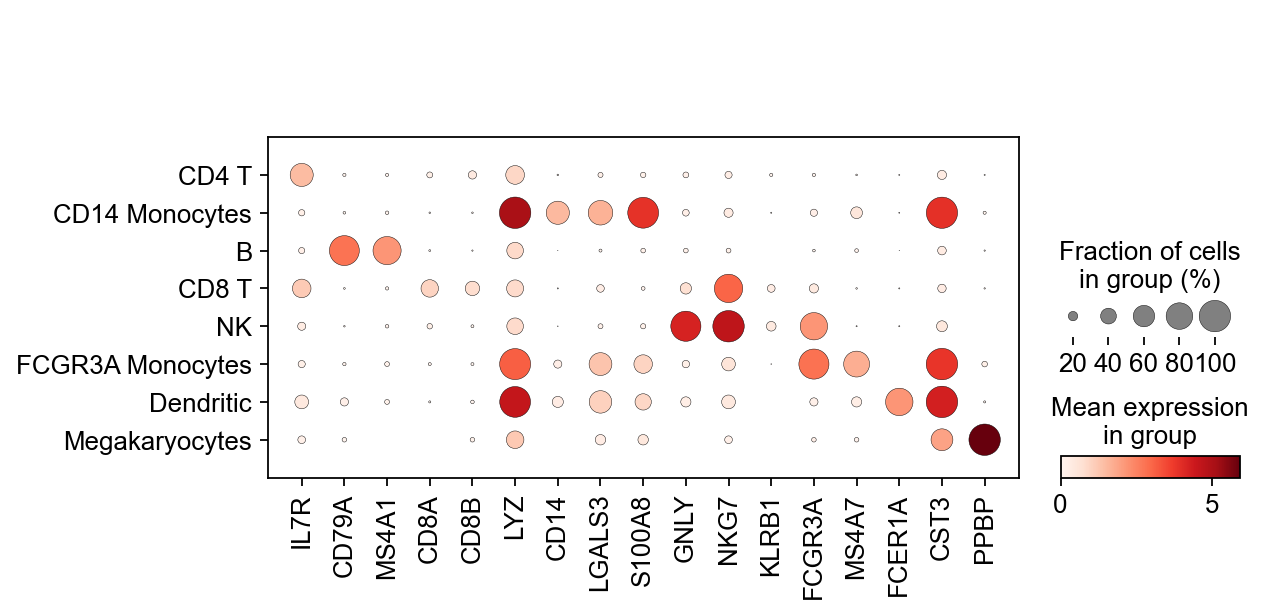

In [182]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


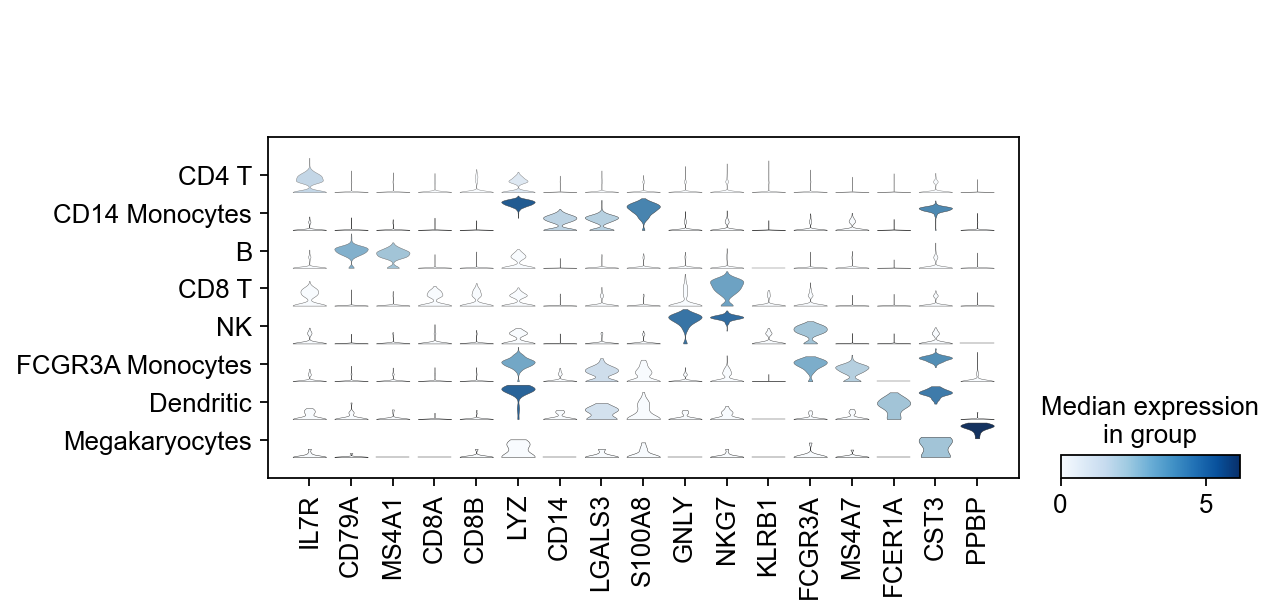

In [183]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


In [184]:
adata


AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [185]:
#set biosample_id value
#biosample = np.random.choice(["mm1_lymph", "hu1_blood", "mm1_blood", "mm2_blood"], size=(adata.n_obs,))
adata.obs["biosample_id"] = "hu1_blood"

#set donor_id value
adata.obs["donor_id"] = "human1"

#set cell_type and cell_type__ontology_label
leiden_list = []
for i in adata.obs["leiden"]:
    leiden_list.append(i)

#leiden categories
leiden_cell = ['CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes', 'Dendritic', 'Megakaryocytes']

#cell_type ontology labels corresponding with above
cell_type_ot = ["CL_0000492", "CL_0001054", "CL_0000236", "CL_0000625", "CL_0000814", "CL_0000860", "CL_0000451", "CL_0000556"]

leiden_to_cell_type = dict(zip(leiden_cell, cell_type_ot))

cell_type_list = []
for i in leiden_list:
    cell_type_list.append(leiden_to_cell_type[i])

adata.obs["cell_type"] = cell_type_list


#cell_type__ontology_label corresponding with above
cell_type_ot_label = ["CD4-positive helper T cell", "CD14-positive monocyte", "B cell", "CD8-positive, alpha-beta T cell", "mature NK T cell", "classical monocyte", "dendritic cell", "megakaryocyte"]

leiden_to_cell_ot = dict(zip(leiden_cell, cell_type_ot_label))

cell_type_ot_list = []
for i in leiden_list:
    cell_type_ot_list.append(leiden_to_cell_ot[i])

adata.obs["cell_type__ontology_label"] = cell_type_ot_list

#set sex value
adata.obs["sex"] = "female"

#set average_intensity value
size_intensity = adata.n_obs
random_intensities = np.random.uniform(-20, 20, size_intensity)
rounded_list = []
for i in random_intensities:
    rounded_list.append(round(i, 3))
    
adata.obs["average_intensity"] = rounded_list

#set species
adata.obs["species"] = "NCBITaxon_9606"

#set species__ontology
adata.obs["species__ontology_label"] = "Homo sapiens"

#set disease label
adata.obs["disease"] = "PATO_0000461"

#set disease__ontology_label
adata.obs["disease__ontology_label"] = "normal"

#set organ label
adata.obs["organ"] = "UBERON_0000178"


#set organ ontology label
adata.obs["organ__ontology_label"] = "blood"

#set library prepartion protocol
adata.obs["library_preparation_protocol"] = "EFO_0009899"

#set library preparation ontology
adata.obs["library_preparation_protocol__ontology_label"] = "10X 3' v2"


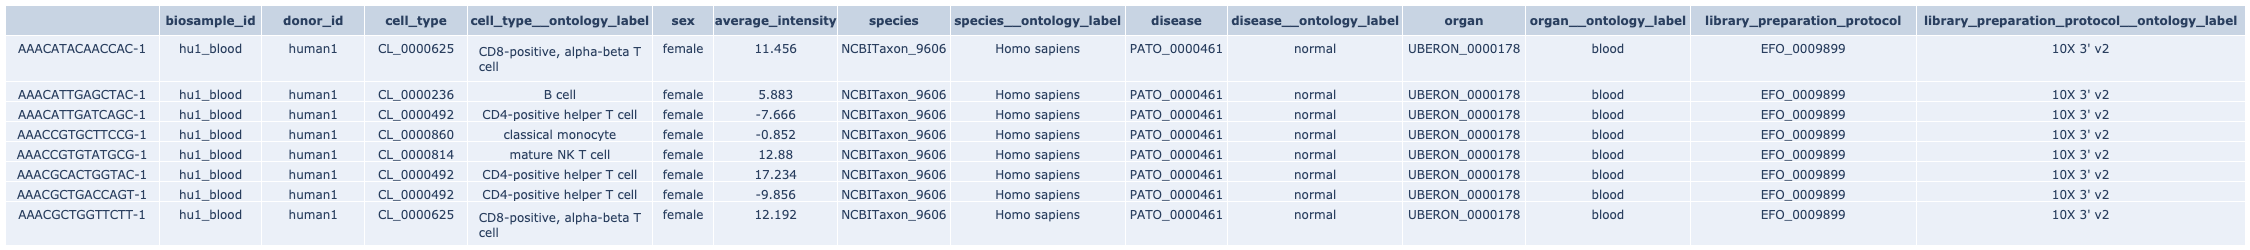

In [186]:
df = sc.get.obs_df(adata, keys = ['biosample_id', 'donor_id', 'cell_type', 'cell_type__ontology_label', 'sex', 'average_intensity', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label'])
#new_df = df.truncate(before="AAACATACAACCAC-1", after="AAACATTGAGCTAC-1")
fig = df2img.plot_dataframe(df, col_width=[75, 50, 50, 50, 90, 30, 60, 55, 85, 50, 85, 60, 80, 110, 160], fig_size=(2250, 250))

df2img.save_dataframe(fig=fig, filename="plot1.png")
